# **Phát hiện biển số xe và dự đoán kí tự trên biển số xe**

## **Phần 2: Dự đoán kí tự**

(Trong notebook này chỉ đào tạo mô hình để có thể dự đoán 1 kí tự riêng lẻ, để có thể áp dụng vào mô hình có code riêng ở 1 file trong. File `character.py` có chứa code để nhận diện các kí tự có trong biển số xe)

---
# **Detecting license plates and predicting characters on license plates**

## **Part 2: Predicting characters**

(In this notebook, I only train the model to be able to predict a single character. To be able to apply it to the model, I have a separate code in a file inside. The file `character.py` contains the code to recognize the characters on the license plate)

## **Import thư viện**

In [2]:
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import os
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import cv2

# 1. Model CNN theo kiến trúc Alexnet 

In [ ]:
def model(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11, 11), strides=(4, 4), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model


## 2. Chia tập train, test

In [34]:

# Define constants
DATASET_PATH = '/kaggle/input/dataset-digit-final/data-character-plate'
MODEL_PATH = '.'
BATCH_SIZE = 64
EPOCHS = 20
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
TARGET_DEPTH = 3
import tensorflow as tf
import numpy as np
import random

# Fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=5,          # Giảm xoay
    width_shift_range=0.1,     # Giảm dịch chuyển
    height_shift_range=0.1,    # Giảm dịch chuyển
    shear_range=0.1,           # Giảm kéo xiên
    zoom_range=0.1,            # Giảm zoom
    horizontal_flip=False,     # Bỏ lật ngang
    # fill_mode='nearest'
)
train_generator = data_gen.flow_from_directory(
    DATASET_PATH, 
    subset='training',
    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
    batch_size=BATCH_SIZE
)

val_generator = data_gen.flow_from_directory(
    DATASET_PATH,
    subset='validation',
    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
    batch_size=BATCH_SIZE
)


Found 29268 images belonging to 36 classes.
Found 7308 images belonging to 36 classes.


## 3. Run model 

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization


# Build model
print("[INFO] Compiling model...")
alexnet = model(train_generator.num_classes, (TARGET_WIDTH, TARGET_HEIGHT, TARGET_DEPTH))

# Compile the model with Adam optimizer and categorical crossentropy loss
alexnet.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model
H = alexnet.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)

[INFO] Compiling model...
Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 168s 348ms/step - accuracy: 0.2911 - loss: 2.9741 - val_accuracy: 0.3044 - val_loss: 2.2970 - learning_rate: 5.0000e-05
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7500 - loss: 0.8435 - val_accuracy: 0.1667 - val_loss: 2.4308 - learning_rate: 5.0000e-05
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 157s 339ms/step - accuracy: 0.8305 - loss: 0.5852 - val_accuracy: 0.9267 - val_loss: 0.2489 - learning_rate: 5.0000e-05
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - accuracy: 0.7656 - loss: 1.1504 - val_accuracy: 0.9167 - val_loss: 0.1853 - learning_rate: 5.0000e-05
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 159s 343ms/step - accuracy: 0.8910 - loss: 0.3659 - val_accuracy: 0.9476 - val_loss: 0.1665 - learning_rate: 5.0000e-05
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.9688 - loss: 0.1666 - val_accuracy: 0.9167 - val_loss: 0.4507 - learning_rate: 5.0000e-05
Epoch 7/20
457/457 ━━

## 4.Đánh giá mô hình qua hàm loss và accuracy

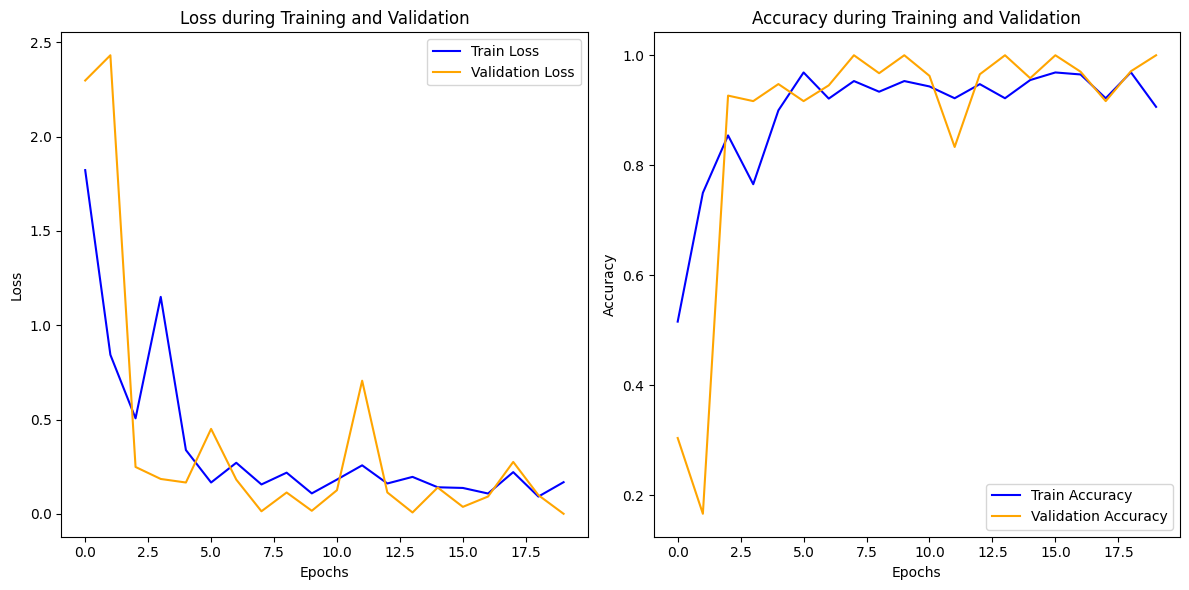

In [37]:

# Vẽ đồ thị
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Train Loss', color='blue')
plt.plot(H.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Lưu mô hình

In [38]:
alexnet.save("/kaggle/working/char_model_01.h5")
print("successfully")

successfully


## 6. Test model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


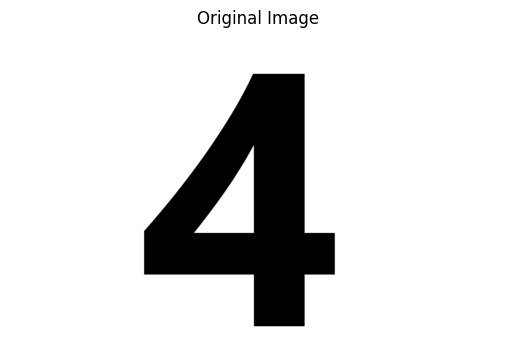

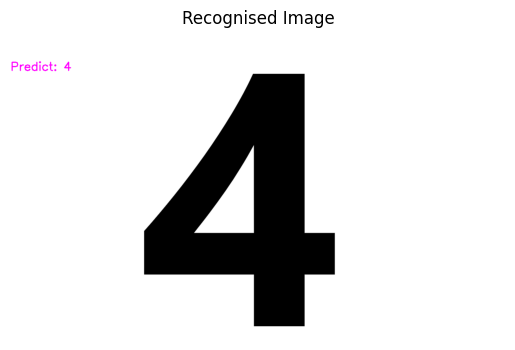

In [39]:

labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Define constants
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
MODEL_PATH = "/kaggle/working/char_model_01.h5"

# Replace argparse with a direct image path
image_path = "/kaggle/input/test-character/test-character/4.png"  # Chỉnh sửa đường dẫn này cho phù hợp

# Load the image
original_image = cv2.imread(image_path)
# Preprocessing the image
image = cv2.resize(original_image, (TARGET_WIDTH, TARGET_HEIGHT))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Load the trained convolutional neural network
model = load_model(MODEL_PATH, compile=False)

# Classify the input image then find the index of the class with the *largest* probability
prob = model.predict(image)[0]
idx = np.argsort(prob)[-1]

# Display original image using matplotlib
plt.imshow(
    cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
)  # Convert BGR to RGB for correct color display
plt.title("Original Image")
plt.axis("off")  # Hide axis
plt.show()

# Display the predicted image with text overlay using matplotlib
cv2.putText(original_image,"Predict: " + labels[idx],(1, 100),cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 0, 255), 2,)
# Display the predicted image using matplotlib
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title("Recognised Image")
plt.axis("off")  # Hide axis
plt.show()